In [1]:
# Load Dataset
import pandas as pd
import json
import numpy as np
import os
FILE_PATH = "./data/training/good/"
FILE_NAME = "log1.json"
# dataDictList is a list of dicts
with open(FILE_PATH+FILE_NAME, 'r') as f:
    dataDictList = json.load(f)

# Update apex.csv
MUST RUN ALL CELLS IN HELPER FUNCTIONS BEFORE FUNCTIONAL

Running this cell will update the "apex.csv" with information based in the "training" folder

In [2]:
# Creates 
apex_df = findAllApex('data/training', update = True)
apex_df

NameError: name 'findAllApex' is not defined

# Helper Functions

Contains 4 functions
##### genList - reads json file into dataframe
##### scale - normalizes dataframe
##### findApex - finds apex coordinate of dataframe
##### findAllApex - returns dataframe with all apexes

## Global Constants

In [3]:
PARTS =  {"nose" : 0, 
  "leftEye" : 1, 
  "rightEye" : 2, 
  "leftEar" : 3, 
  "rightEar" : 4, 
  "leftShoulder" : 5, 
  "rightShoulder" : 6, 
  "leftElbow" : 7, 
  "rightElbow" : 8, 
  "leftWrist" : 9, 
  "rightWrist" : 10, 
  "leftHip" : 11, 
  "rightHip" : 12, 
  "leftKnee" : 13, 
  "rightKnee" : 14, 
  "leftAnkle" : 15, 
  "rightAnkle" : 16}

requiredParts = ["nose", 
#   "leftEye", 
#   "rightEye", 
#   "leftEar", 
#   "rightEar", 
  "leftShoulder", 
  "rightShoulder", 
#   "leftElbow", 
#   "rightElbow", 
#   "leftWrist", 
#   "rightWrist", 
  "leftHip", 
  "rightHip", 
  "leftKnee", 
  "rightKnee", 
  "leftAnkle", 
  "rightAnkle"
]

IMAGE_X_SIZE = 600
IMAGE_Y_SIZE = 450

## Read json file
genList reads a json file and creates an table of the X and Y coordinates

In [4]:
def genList(dataDictList, requiredParts, startIndex, stopIndex):
    '''
    @args
    dataDictList - json load
    requiredParts - ["nose", etc.]
    startIndex - relative timestamp to start. 0
    stopIndex - relative timestamp to stop. len(dataDictList)
    @returns
    [#, x], [#, y]
    '''
    dataListX = None
    dataListY = None
    for _frame in range(startIndex, stopIndex):
        if dataListX is None:
            dataListX = [[dataDictList[_frame]['keypoints'][PARTS[X]]['position']['x'] for X in requiredParts]]
            dataListY = [[dataDictList[_frame]['keypoints'][PARTS[X]]['position']['y'] for X in requiredParts]]
        else:
            dataListX = dataListX + [[dataDictList[_frame]['keypoints'][PARTS[_part]]['position']['x'] for _part in requiredParts]]
            dataListY = dataListY + [[dataDictList[_frame]['keypoints'][PARTS[_part]]['position']['y'] for _part in requiredParts]]
    
    dataListX = np.array(dataListX) # [[x]]
    dataListY = np.array(dataListY) # [[y]]
    newDataListX = np.reshape(dataListX, (-1,len(requiredParts))) 
    newDataListY = np.reshape(dataListY, (-1,len(requiredParts))) #[#instance, (y) for each keypoint]
    print(str(len(newDataListX)) + " entries")
    return newDataListX, newDataListY


newDataListX, newDataListY = genList(dataDictList, requiredParts, 0, len(dataDictList))


116 entries


## Normalization
Normalizes coordinates for our model

In [5]:
'''
 This has 2 parts-
 Resize, by identifying and scaling as bounding box, and then (Min-Max) Normalize
 Note: The broadcasting here is element-wise. 
 Sources:
 [1] https://medium.com/tensorflow/move-mirror-an-ai-experiment-with-pose-estimation-in-the-browser-using-tensorflow-js-2f7b769f9b23
 [2] https://raw.githubusercontent.com/paulvollmer/posenet-keypoints-normalization/master/src/index.js
 

''' 

def scale(newDataListX, newDataListY):
    '''
    Assumes dataList of form [#instance, [(x,y) for each keypoint]]
    Possible optim: bounding box wont change much across frames
    '''
    # Bounding Box
    maxX = np.max(newDataListX, axis=1)
    minX = np.min(newDataListX, axis=1)
    maxY = np.max(newDataListY, axis=1)
    minY = np.min(newDataListY, axis=1)
    assert(len(minY)==len(newDataListX))
    l2Data = np.concatenate((newDataListX, newDataListY), axis=1)
    # Reset to Origin and Scale
    for _data in range(0, len(newDataListX)):
        l2Data[_data] = l2Data[_data] / np.linalg.norm(l2Data[_data]) # L2 norm if the need be
    return l2Data[:,:newDataListX.shape[-1]], l2Data[:,newDataListY.shape[-1]:]

scaledDataX, scaledDataY = scale(newDataListX, newDataListY)


x_key=pd.DataFrame(scaledDataX)
y_key=pd.DataFrame(scaledDataY)
x_key.columns=requiredParts
y_key.columns=requiredParts
keydoc=FILE_NAME[:-5]
x_key.to_csv(FILE_PATH+keydoc+"_x.csv")
y_key.to_csv(FILE_PATH+keydoc+"_y.csv")

## Find Apex
Finds the normalized apex for a json file

In [6]:
def findApex(xTbl, yTbl):
    minColumnIndex = yTbl['leftHip'].idxmin()
    print("Entry with apex = " + str(minColumnIndex))
    xTblApex = xTbl.iloc[minColumnIndex,:]
    yTblApex = yTbl.iloc[minColumnIndex,:]
    apex = []
    for i in range(len(xTblApex)):
        xTblVal = xTblApex[i]
        yTblVal = yTblApex[i]
        apex.append(xTblVal)
        apex.append(yTblVal)
    return apex

## Find All Apexes
Runs findApex on every json file in training, creating dataframe of all apexes classified based off the folder they're in

In [7]:
def findAllApex(training_path, update):
    print("Starting findAllApex")
    print("--------------------")
    # Creats index names for final table, each part and each coordinate having separate columns
    columnIndices = []
    for index in requiredParts:
        columnIndices.append(index + "_x")
        columnIndices.append(index + "_y")
    columnIndices.append("good")
        
    #Creates list of paths for json files
    goodJson = []
    for file in os.listdir(training_path + "/good"):
        if file.endswith(".json"):
            goodJson.append(os.path.join(training_path + "/good", file))
    badJson = []
    for file in os.listdir(training_path + "/bad"):
        if file.endswith(".json"):
            badJson.append(os.path.join(training_path + "/bad", file))
    jsonList = [goodJson, badJson]
    
    apexes = []
    type = 1
    print("Good squats: " + str(len(goodJson)))
    print("Bad squats: " + str(len(badJson)))
    print("--------------------")
    for jsonFolder in jsonList:
        for path in jsonFolder:
            print("File path: " + path)
            with open(path, 'r') as f:
                dataDictList = json.load(f)
            newDataListX, newDataListY = genList(dataDictList, requiredParts, 0, len(dataDictList))
            scaledDataX, scaledDataY = scale(newDataListX, newDataListY)
            x_key=pd.DataFrame(scaledDataX)
            y_key=pd.DataFrame(scaledDataY)
            x_key.columns=requiredParts
            y_key.columns=requiredParts
            apex_point = findApex(x_key, y_key)
            apex_point.append(type)
            apexes.append(apex_point)
            print("--------------------")
        type = 0
    apex_df = pd.DataFrame(apexes, columns = columnIndices)
    apex_df.index.name = 'entry'
    if update == True:
        apex_df.to_csv('data/apex.csv')
        print("apex.csv updated")
    print("Finish findAllApex")
    print("Found apexes of all "+ str(len(apex_df)) + " squats")
    return apex_df

# Visualizations

In [8]:
# Choose if you want to plot X or Y

<IPython.core.display.Javascript object>


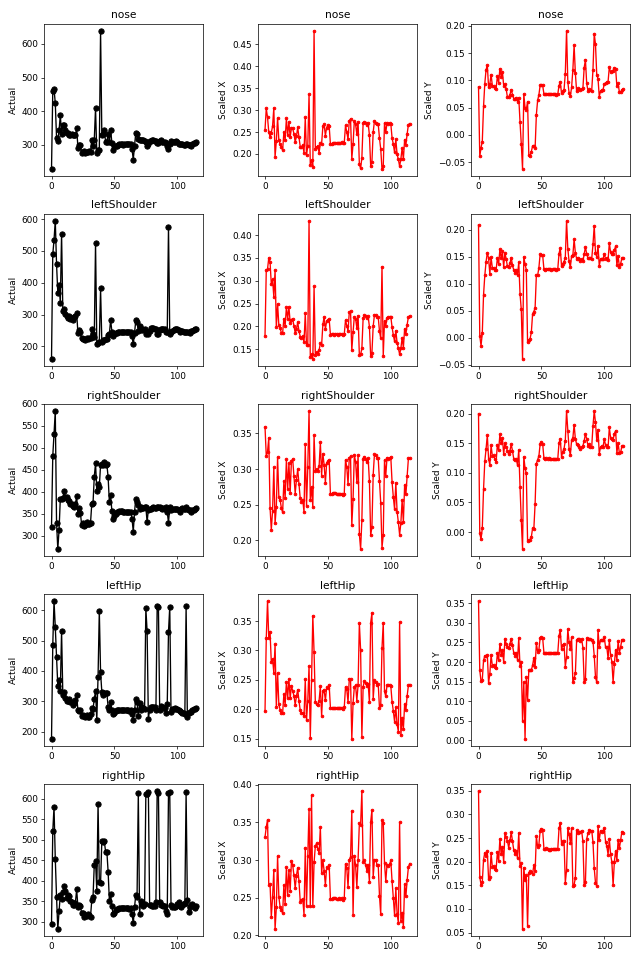

In [9]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
num_graphs = 5
index = 0
for sub in range(0, num_graphs, 1):
    plt.subplot(5, 3, 3*sub+1)
    plt.plot(newDataListX[:,index], 'ko-')
    plt.title(requiredParts[index])
    plt.ylabel('Actual')

    plt.subplot(5, 3, 3*sub+2)
    plt.plot(scaledDataX[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('Scaled X')
    
    plt.subplot(5, 3, 3*sub+3)
    plt.plot(scaledDataY[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('Scaled Y')
    index = index + 1

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


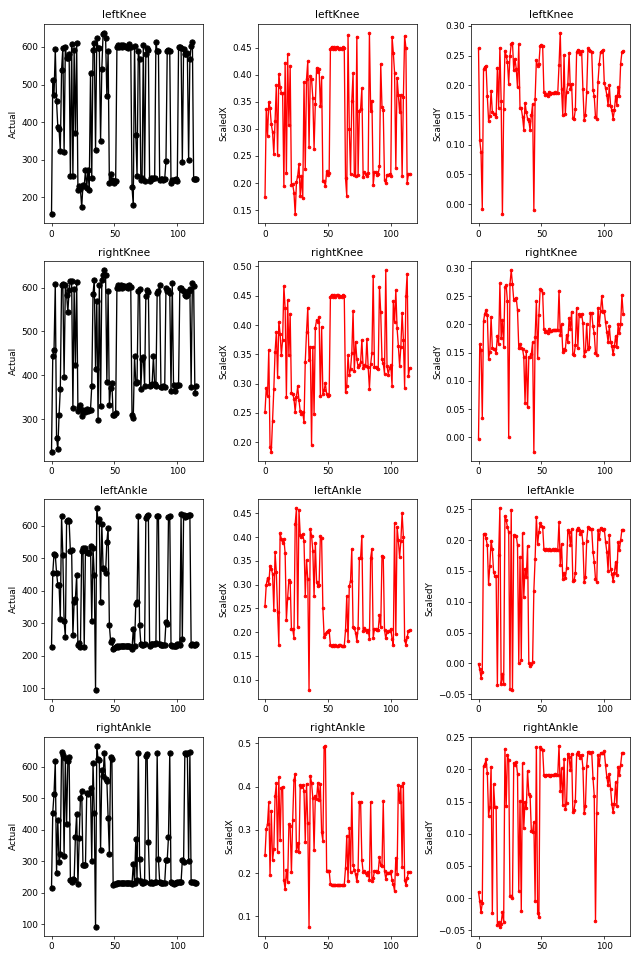

In [10]:
index=5
fig=plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
for sub in range(0, 4, 1):
    plt.subplot(4, 3, 3*sub+1)
    plt.plot(newDataListX[:,index], 'ko-')
    plt.title(requiredParts[index])
    plt.ylabel('Actual')
    plt.subplot(4, 3, 3*sub+2)
    plt.plot(scaledDataX[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('ScaledX')
    plt.subplot(4, 3, 3*sub+3)
    plt.plot(scaledDataY[:,index],  'r.-')
    plt.title(requiredParts[index])
    plt.ylabel('ScaledY')
    index = index+1
    
plt.tight_layout()
plt.show()

In [21]:
# fig=plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
# for sub in range(0, 4, 1):
#     plt.subplot(5, 3, (3*sub+1))
#     plt.plot(newDataListX[:,index], 'ko-')
#     plt.title(requiredParts[index])
#     plt.ylabel('Actual')
#     plt.subplot(5, 3, (3*sub+2))
#     plt.plot(scaledDataX[:,index],  'r.-')
#     plt.title(requiredParts[index])
#     plt.ylabel('ScaledX')
#     plt.subplot(5, 3, (3*sub+3))
#     plt.plot(scaledDataY[:,index],  'r.-')
#     plt.title(requiredParts[index])
#     plt.ylabel('ScaledY')
#     index = index+1
    
# plt.tight_layout()
# plt.show()

fig=plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x_key);

In [23]:
#apex_df['good']

Test Accuracy:  0.0
